In [1]:
! pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.4 MB/s eta 0:00:00


In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import random
import math
import os

import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Conv2DTranspose
from keras.layers import UpSampling2D
from sklearn.preprocessing import StandardScaler

import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

In [5]:
print("Tensorflow Version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

Tensorflow Version: 2.15.0
Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Toy Dataset

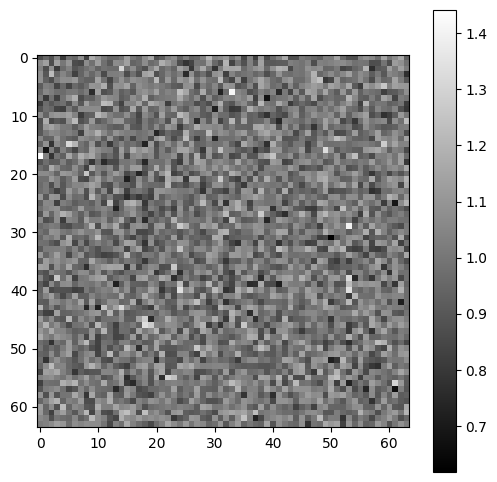

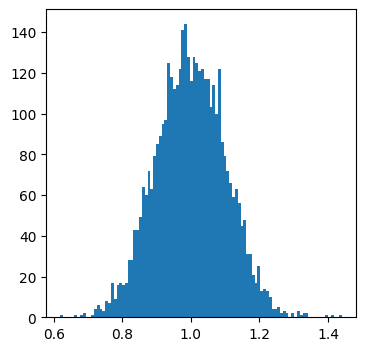

In [3]:
def make_image(shape, noise_mean = 1,
                        noise_std = 1,
                        num_obj_min = 1,
                        num_obj_max = 20,
                        amp_min = 1,
                        amp_max = 5,
                        size_min = 0.4,
                        size_max = 1.5):
    rows = shape[0]
    cols = shape[1]

    # add noise
    noise_layer = np.random.normal(loc = noise_mean, scale = noise_std, size = shape)
    image = noise_layer

    num_obj = np.random.randint(num_obj_min, num_obj_max)

    for i in range(num_obj):
        sigma = np.random.uniform(size_min,size_max)
        amp = np.random.uniform(amp_min,amp_max)
        x0, y0 = np.random.randint(0, rows), np.random.randint(0, cols)
        x, y = np.meshgrid(np.arange(cols), np.arange(rows))
        gaussian = amp*np.exp(-((x-x0)**2 + (y-y0)**2) / (2*sigma**2))

        image += gaussian

    image = np.array(image).reshape(shape[0], shape[1],1)
    return image

# VISUALIZE

# init some variables
shape = (64,64)
noise_mean = 1
noise_std = 0.1
num_obj_min = 0
num_obj_max = 20
amp_min = 1
amp_max = 5
size_min = 0.4
size_max = 2

# test plot
image = make_image(shape = shape,
                    noise_mean = noise_mean,
                    noise_std = noise_std,
                    num_obj_min = num_obj_min,
                    num_obj_max = num_obj_max,
                    amp_min = amp_min,
                    amp_max = amp_max,
                    size_min = size_min,
                    size_max = size_max)

plt.figure(figsize = (6,6))
plt.imshow(image.reshape(shape[0], shape[1]), cmap = 'gray')
plt.colorbar()

# histogram
image_flatten = np.array(image).flatten()
np.shape(image_flatten)
plt.figure(figsize = (4,4))
histogram = plt.hist(image_flatten, density = False, bins = 100)


# batches
def make_image_batch(batch_size,
                    shape,
                    noise_mean,
                    noise_std,
                    num_obj_min,
                    num_obj_max,
                    amp_min,
                    amp_max,
                    size_min,
                    size_max):

    images = []
    for i in range(batch_size):
        image = make_image(shape, noise_mean, noise_std, num_obj_min, num_obj_max, amp_min, amp_max, size_min, size_max)
        images.append(image)

    return np.array(images)


In [7]:
# LOAD IMAGES INTO MEMORY

# set noise/object parameters
noise_mean = 1
noise_std = 0.1
num_obj_min = 0
num_obj_max = 20
amp_min = 1
amp_max = 5
size_min = 0.4
size_max = 2

# set image size
shape = (64,64)
input_shape = (shape[0],shape[1],1)

# set num images
num_imgs = 40000

synth_imgs = make_image_batch(batch_size=num_imgs,
                                shape=shape,
                                noise_mean=noise_mean,
                                noise_std=noise_std,
                                num_obj_min=num_obj_min,
                                num_obj_max=num_obj_max,
                                amp_min=amp_min,
                                amp_max=amp_max,
                                size_min=size_min,
                                size_max=size_max)
print(np.shape(synth_imgs))

# sklearn standard scaler
synth_imgs = synth_imgs
flattened_synth_imgs = np.reshape(synth_imgs, (num_imgs, shape[0]*shape[1]))
scaler = StandardScaler()
scaler.fit(flattened_synth_imgs)
synth_imgs_scaled = scaler.transform(flattened_synth_imgs)
synth_imgs_scaled = np.reshape(synth_imgs_scaled, (num_imgs,shape[0],shape[1],1))

synth_train = synth_imgs_scaled[0:int(num_imgs*0.9)]
synth_test = synth_imgs_scaled[int(num_imgs*0.9):]
print(np.shape(synth_train))
print(np.shape(synth_test))


def make_data(num_imgs):

    synth_imgs = make_image_batch(num_imgs, shape, noise_mean, noise_std, num_obj_min, num_obj_max)

    # sklearn standard scaler
    synth_imgs = synth_imgs
    flattened_synth_imgs = np.reshape(synth_imgs, (num_imgs, shape[0]*shape[1]))
    scaler = StandardScaler()
    scaler.fit(flattened_synth_imgs)
    synth_imgs_scaled = scaler.transform(flattened_synth_imgs)
    synth_imgs_scaled = np.reshape(synth_imgs_scaled, (num_imgs,shape[0],shape[1],1))

    synth_train = synth_imgs_scaled[0:int(num_imgs*0.9)]
    synth_test = synth_imgs_scaled[int(num_imgs*0.9):]
    return synth_train, synth_test


(40000, 64, 64, 1)
(36000, 64, 64, 1)
(4000, 64, 64, 1)


In [8]:
# GAE
def create_1D_mask(encoding_dim, comp_param):
    ones_length = int(comp_param)
    zeros_length = int(encoding_dim - ones_length)
    ones = tf.ones((ones_length))
    zeros = tf.zeros((zeros_length))
    mask = tf.concat([ones, zeros], axis = 0)
    mask = tf.reshape(mask, (1, encoding_dim,))

    return mask


class GAE(keras.Model):

    def gae_compile(self,
                    encoder,
                    mean_model,
                    var_model,
                    encoder_optimizer,
                    mean_optimizer,
                    var_optimizer,
                    epsilon=1,
                    encoding_dim = 64,
                    **kwargs):

        super().compile()
        self.mean_optimizer = mean_optimizer
        self.var_optimizer = var_optimizer
        self.encoder_optimizer = encoder_optimizer
        self.mle_loss_tracker = keras.metrics.Mean(name="mle_loss")
        self.mse_tracker = keras.metrics.Mean(name = "mse")
        self.epsilon = epsilon
        self.mean_model = mean_model
        self.var_model = var_model
        self.encoder = encoder
        self.encoding_dim = encoding_dim

    def train_step(self, data):
        x = data

        # limit comp_param minimum to 16x compression
        lower_lim = int(shape[0]*shape[1] / 16)
        comp_param = random.randint(1, self.encoding_dim)

        with tf.GradientTape(persistent = True) as tape:
            # forward pass mean
            codes = self.encoder(x, training = True)

            """masking process (STOCHASTIC TUNE)"""
            mask = create_1D_mask(encoding_dim = self.encoding_dim, comp_param=comp_param)
            codes = tf.multiply(codes, mask)

            mean_img = self.mean_model(codes, training = True)

            """Calculate MSE loss"""
            mse = K.mean(K.square(mean_img - x))

        # apply gradients to mean model
        mean_grads = tape.gradient(mse, self.mean_model.trainable_weights)
        encoder_grads = tape.gradient(mse, self.encoder.trainable_weights)
        self.encoder_optimizer.apply_gradients(zip(encoder_grads, self.encoder.trainable_weights))
        self.mean_optimizer.apply_gradients(zip(mean_grads, self.mean_model.trainable_weights))

        with tf.GradientTape(persistent = True) as tape:
            # forward pass variance
            codes = self.encoder(x, training = True)

            """masking process"""
            mask = create_1D_mask(encoding_dim = self.encoding_dim, comp_param=comp_param)
            codes = tf.multiply(codes, mask)

            mean_img = self.mean_model(codes, training = False)
            var_img = self.var_model(codes, training = True)

            """Calulate MLE loss"""
            mle_loss = K.log(var_img+self.epsilon) + K.square(mean_img - x) / (var_img+self.epsilon)
            mle_loss = K.mean(mle_loss)

        # apply gradients to var model
        var_grads = tape.gradient(mle_loss, self.var_model.trainable_weights)
        encoder_grads = tape.gradient(mle_loss, self.encoder.trainable_weights)
        self.encoder_optimizer.apply_gradients(zip(encoder_grads, self.encoder.trainable_weights))
        self.var_optimizer.apply_gradients(zip(var_grads, self.var_model.trainable_weights))

        self.mse_tracker.update_state(mse)
        self.mle_loss_tracker.update_state(mle_loss)

        return {
            "mle_loss": self.mle_loss_tracker.result(),
            "mse": self.mse_tracker.result()
        }


    def test_step(self, data):
        x = data

        # limit comp_param minimum to 16x compression
        lower_lim = int(shape[0]*shape[1] / 16)
        comp_param = random.randint(1, self.encoding_dim)
        codes = self.encoder(x, training = False)

        """masking process (STOCHASTIC TUNE)"""
        mask = create_1D_mask(encoding_dim = self.encoding_dim, comp_param=comp_param)
        codes = tf.multiply(codes, mask)

        mean_img = self.mean_model(codes, training = False)
        var_img = self.var_model(codes, training = False)

        """Calculate MSE loss"""
        mse = K.mean(K.square(mean_img - x))

        """Calulate MLE loss"""
        mle_loss = K.log(var_img+self.epsilon) + K.square(mean_img - x) / (var_img+self.epsilon)
        mle_loss = K.mean(mle_loss)

        self.mse_tracker.reset_states()
        self.mle_loss_tracker.reset_states()
        self.mse_tracker.update_state(mse)
        self.mle_loss_tracker.update_state(mle_loss)

        return{
            "mle_loss": self.mle_loss_tracker.result(),
            "mse": self.mse_tracker.result()
        }

    def custom_predict(self, data, comp_param):
        x = data
        # forward pass
        codes = self.encoder(x, training = False)
        # masking process
        mask = create_1D_mask(encoding_dim = self.encoding_dim, comp_param = comp_param)
        codes = tf.multiply(codes, mask)

        mean_img = self.mean_model(codes, training = False)
        var_img = self.var_model(codes, training = False)

        return mean_img, var_img


In [11]:
# set hyperparameters
encoding_dim = 1024
epochs = 50
batch_size = 64
steps_per_epoch = 1000
encoding_filters = [512, 256, 128, 128]
decoding_filters = [128, 128, 256, 512]
encoding_dense = []
decoding_dense = []
learning_rate = 0.0001
epsilon = noise_std**2

compression_ratio = (shape[0]*shape[1]) / (encoding_dim)

# autoencoder architecture

with tf.device(device_name = '/device:GPU:0'):

    input = keras.Input(shape = input_shape)
    enc_layer = input

    # encoder
    for filter in encoding_filters:
        enc_layer = keras.layers.Conv2D(filter, (3,3), activation = 'relu',padding = 'same')(enc_layer)
        #enc_layer = keras.layers.LeakyReLU(alpha = 0.3)(enc_layer)
        enc_layer = keras.layers.BatchNormalization()(enc_layer)
        enc_layer = keras.layers.MaxPooling2D((2,2), padding = 'same')(enc_layer)
        enc_layer = keras.layers.Dropout(0.1)(enc_layer)

    shape_before_flatten = K.int_shape(enc_layer)[1:]
    enc_layer = keras.layers.Flatten()(enc_layer)

    for outputs in encoding_dense:
        enc_layer = keras.layers.Dense(outputs, activation = 'relu')(enc_layer)
        #enc_layer = keras.layers.LeakyReLU(alpha = 0.3)(enc_layer)
        enc_layer = keras.layers.BatchNormalization()(enc_layer)
        enc_layer = keras.layers.Dropout(0.1)(enc_layer)


    enc_layer = keras.layers.Dense(encoding_dim, activation = 'relu')(enc_layer)
    #enc_layer = keras.layers.LeakyReLU(alpha = 0.3)(enc_layer)


    # decoder mean
    mean_layer = enc_layer
    for outputs in decoding_dense:
        mean_layer = keras.layers.Dense(outputs, activation = 'relu')(mean_layer)
        #enc_layer = keras.layers.LeakyReLU(alpha = 0.3)(enc_layer)
        mean_layer = keras.layers.BatchNormalization()(mean_layer)
        mean_layer = keras.layers.Dropout(0.1)(mean_layer)

    mean_layer = keras.layers.Dense(shape_before_flatten[0]*shape_before_flatten[1]*shape_before_flatten[2], activation = 'relu')(mean_layer)
    #dense_1 = keras.layers.LeakyReLU(alpha = 0.3)(dense_1)
    mean_layer = keras.layers.Reshape(target_shape = (shape_before_flatten[0],shape_before_flatten[1],shape_before_flatten[2]))(mean_layer)

    for filter in decoding_filters:
        mean_layer = keras.layers.Conv2DTranspose(filter, (3,3), activation = 'relu', padding = 'same')(mean_layer)
        #mean_layer = keras.layers.LeakyReLU(alpha = 0.3)(mean_layer)
        mean_layer = keras.layers.BatchNormalization()(mean_layer)
        mean_layer = keras.layers.UpSampling2D((2,2))(mean_layer)
        mean_layer = keras.layers.Dropout(0.1)(mean_layer)

    mean_predict = keras.layers.Conv2DTranspose(1, (3,3), activation = 'relu', padding = 'same')(mean_layer)



    # decoder variance
    var_layer = enc_layer
    for outputs in decoding_dense:
        var_layer = keras.layers.Dense(outputs, activation = 'relu')(var_layer)
        #enc_layer = keras.layers.LeakyReLU(alpha = 0.3)(enc_layer)
        var_layer = keras.layers.BatchNormalization()(var_layer)
        var_layer = keras.layers.Dropout(0.1)(var_layer)

    var_layer = keras.layers.Dense(shape_before_flatten[0]*shape_before_flatten[1]*shape_before_flatten[2], activation = 'relu')(var_layer)
    #dense_2 = keras.layers.LeakyReLU(alpha = 0.3)(dense_2)
    var_layer = keras.layers.Reshape(target_shape = (shape_before_flatten[0],shape_before_flatten[1],shape_before_flatten[2]))(var_layer)

    for filter in decoding_filters:
        var_layer = keras.layers.Conv2DTranspose(filter, (3,3), activation = 'relu', padding = 'same')(var_layer)
        #var_layer = keras.layers.LeakyReLU(alpha = 0.3)(var_layer)
        var_layer = keras.layers.BatchNormalization()(var_layer)
        var_layer = keras.layers.UpSampling2D((2,2))(var_layer)
        var_layer = keras.layers.Dropout(0.1)(var_layer)

    var_predict = keras.layers.Conv2DTranspose(1, (3,3), activation = 'relu', padding = 'same')(var_layer)


    mean_model = keras.Model(enc_layer, mean_predict, name = 'mean_model')
    var_model = keras.Model(enc_layer, var_predict, name = 'var_model')
    encoder = keras.Model(input, enc_layer, name = 'encoder')


    autoencoder_C = GAE(input, [mean_predict, var_predict])
    mean_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    var_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    encoder_optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

    autoencoder_C.gae_compile(mean_model = mean_model, var_model = var_model, encoder = encoder,
                                mean_optimizer=mean_optimizer, var_optimizer = var_optimizer,
                                encoder_optimizer = encoder_optimizer,
                                epsilon = epsilon,
                                encoding_dim = encoding_dim
                                )

    encoder.summary()
    mean_model.summary()
    var_model.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 512)       5120      
                                                                 
 batch_normalization_12 (Ba  (None, 64, 64, 512)       2048      
 tchNormalization)                                               
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 32, 32, 512)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 32, 32, 512)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 256)       1179

In [12]:
# WANDB INIT

# start run, tracking hyperparameters
run = wandb.init(mode = 'disabled',
    #set project
    project = "gae",

    config = {
        "epochs": epochs,
        "batch_size": batch_size,
        "encoding_dim": encoding_dim,
        "encoder_filters": encoding_filters,
        "encoder_dense": encoding_dense,
        "decoder_dense" : decoding_dense,
        "decoder_filters": decoding_filters,
        "input_shape": input_shape,
        "shape": shape,
        "noise_mean": noise_mean,
        "noise_std": noise_std,
        "num_obj_min": num_obj_min,
        "num_obj_max": num_obj_max,
        "amp_min": amp_min,
        "amp_max": amp_max,
        "size_min": size_min,
        "size_max": size_max,
        "steps_per_epoch": steps_per_epoch,
        "learning_rate": learning_rate,
        "comp_ratio": compression_ratio,
        "num_imgs": num_imgs,
        "epsilon": epsilon,
    }
)


# FIT

with tf.device(device_name = '/device:GPU:0'):
    autoencoder_C.fit([synth_train], epochs = epochs, batch_size = batch_size, shuffle = True,
                    validation_data = [synth_test],
                    callbacks = [WandbMetricsLogger(log_freq=5)
                    #WandbModelCheckpoint("models/gae_model/gae_weights", save_weights_only = True, monitor = 'val_loss')
                    ])

Epoch 1/50
563/563 [==============================] - 69s 105ms/step - mle_loss: 4.6709 - mse: 0.9989 - val_mle_loss: 93.9850 - val_mse: 1.0897
Epoch 2/50
563/563 [==============================] - 58s 104ms/step - mle_loss: 1.9277 - mse: 0.8183 - val_mle_loss: 63.7983 - val_mse: 1.0886
Epoch 3/50
563/563 [==============================] - 58s 104ms/step - mle_loss: 1.3116 - mse: 0.7353 - val_mle_loss: 1.1929 - val_mse: 1.0858
Epoch 4/50
563/563 [==============================] - 58s 104ms/step - mle_loss: 0.8995 - mse: 0.6863 - val_mle_loss: 3.2966 - val_mse: 1.0901
Epoch 5/50
563/563 [==============================] - 58s 104ms/step - mle_loss: 0.5329 - mse: 0.6222 - val_mle_loss: 2.4860 - val_mse: 1.0859
Epoch 6/50
563/563 [==============================] - 58s 104ms/step - mle_loss: 0.2209 - mse: 0.5680 - val_mle_loss: 2.6758 - val_mse: 1.0836
Epoch 7/50
563/563 [==============================] - 58s 104ms/step - mle_loss: 0.0629 - mse: 0.5310 - val_mle_loss: 2.0461 - val_mse: 1.08

KeyboardInterrupt: 

In [ ]:
wandb.finish()

batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/mle_loss,█▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/mse,█▆▆▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/mle_loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/mse,█▇▇▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_mle_loss,▇▇█▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_mse,███▇▆▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
batch/batch_step,19875


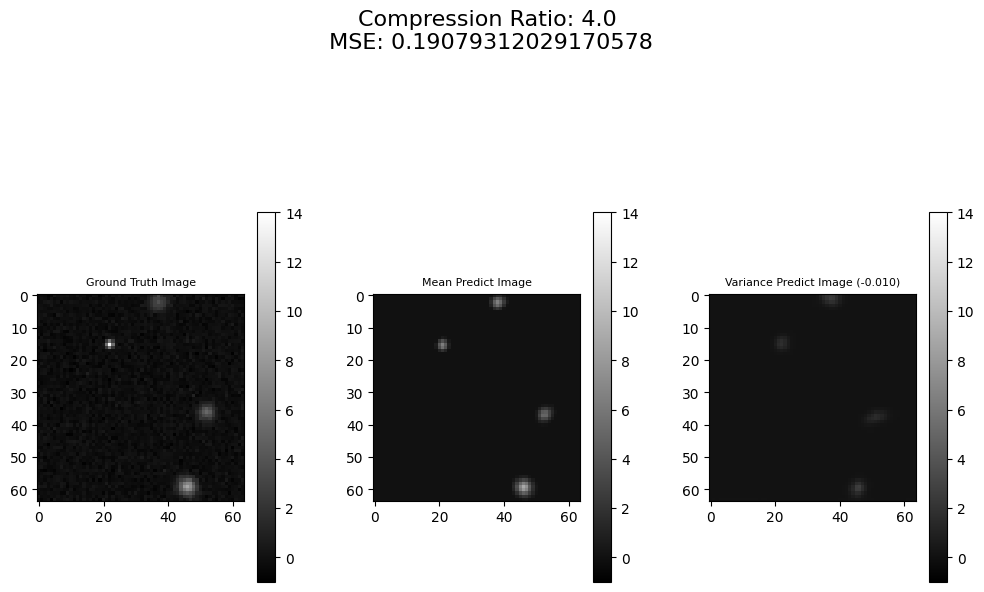

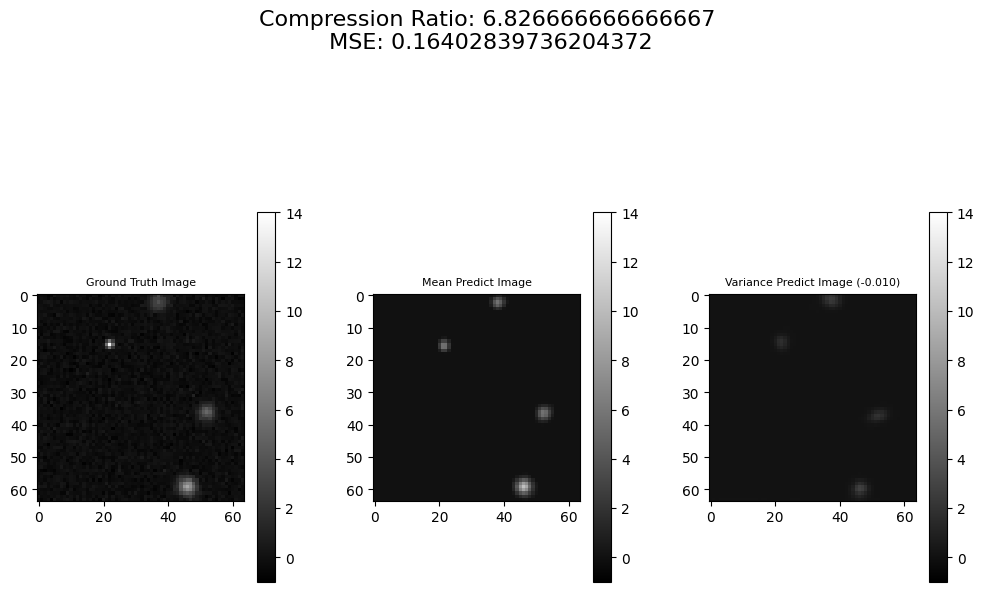

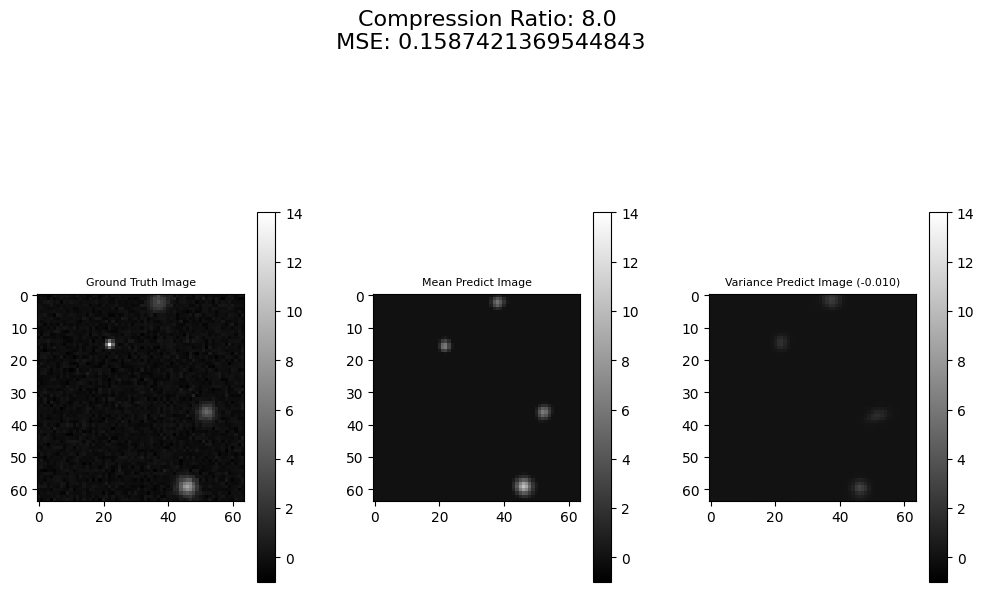

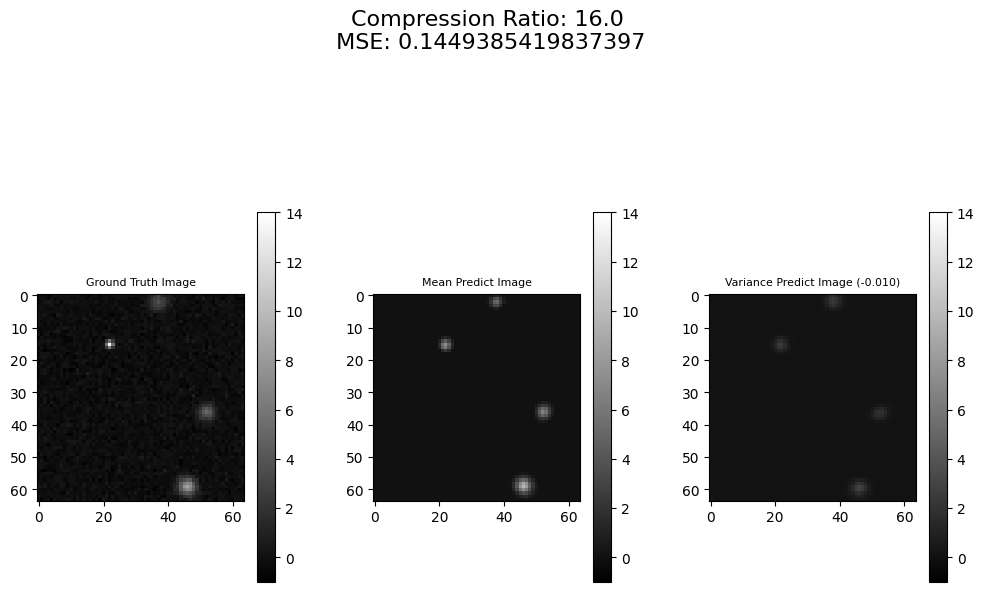

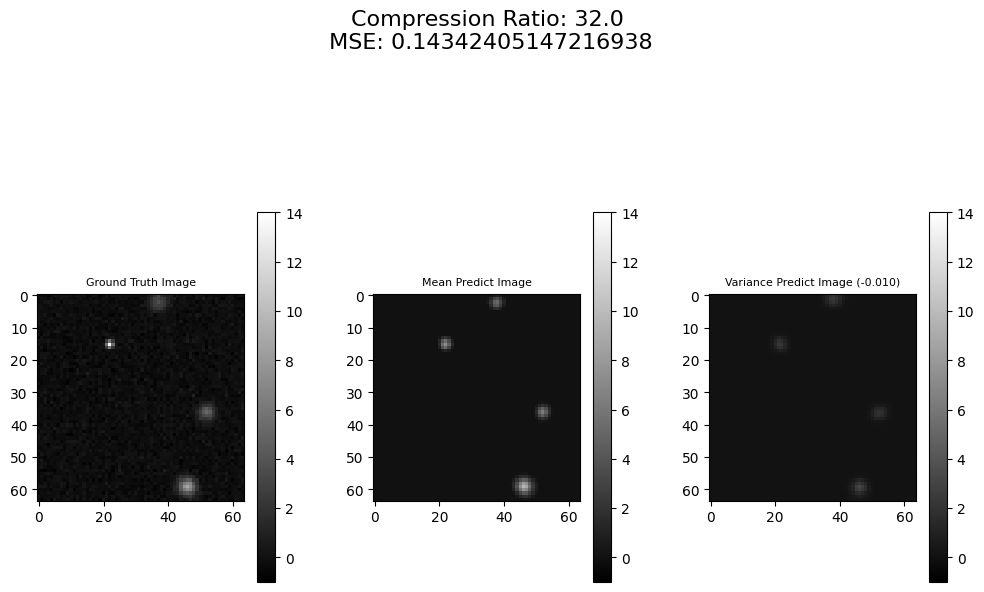

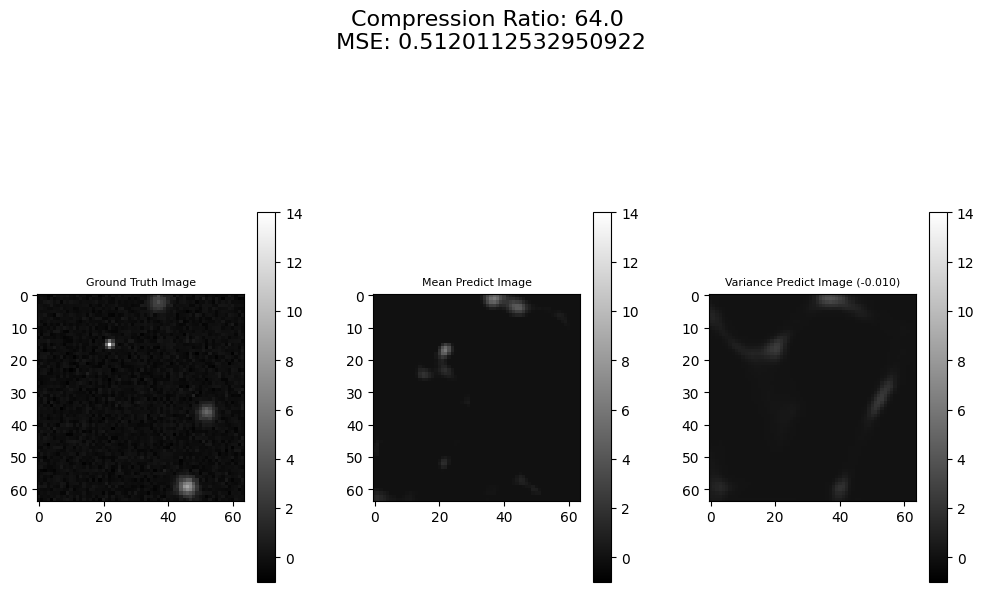

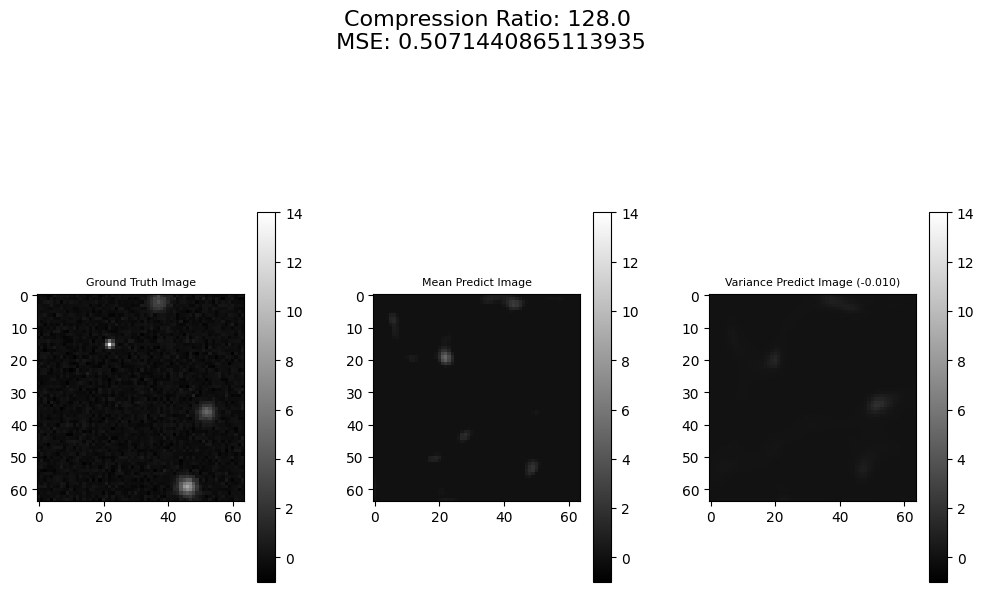

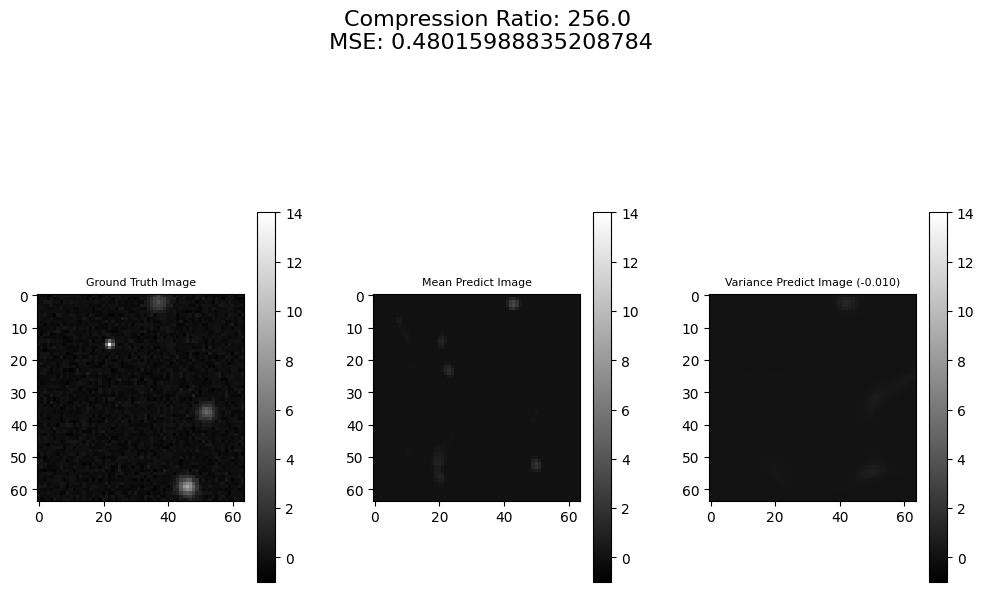

In [ ]:
# test tuning reconstruction

vmin = -1
vmax = 14

index = random.randint(0, len(synth_test)-1)
ground_truth_img = synth_test[index].reshape(shape)
test_img = synth_test[index].reshape(1,shape[0],shape[1],1)

comp_params = [1024, 600, 512, 256, 128, 64, 32, 16]

for comp_param in comp_params:

    with tf.device(device_name = '/device:GPU:0'):
        mean_pred_img, var_pred_img = np.array(autoencoder_C.custom_predict(test_img, comp_param = comp_param))
        mean_pred_img = mean_pred_img.reshape(shape)
        var_pred_img = var_pred_img.reshape(shape)

    mse = (np.array(mean_pred_img) - np.array(ground_truth_img))**2
    mse = np.mean(mse)

    # create a figure with multiple subplots
    fig, axs = plt.subplots(1, 3, figsize=(12, 8), gridspec_kw={'wspace': 0.3, 'hspace': 0.3})
    fig.suptitle('Compression Ratio: {}'.format(shape[0]*shape[1] / comp_param) + '\n MSE: {}'.format(mse), fontsize=16)


    # plot each image on a separate subplot
    im0 = axs[0].imshow(ground_truth_img, cmap='gray', vmin = vmin, vmax = vmax)
    axs[0].set_title('Ground Truth Image', fontsize = 7.9)
    fig.colorbar(im0, ax=axs[0], shrink=0.6)

    im1 = axs[1].imshow(mean_pred_img, cmap='gray', vmin = vmin, vmax = vmax)
    axs[1].set_title('Mean Predict Image', fontsize = 7.9)
    fig.colorbar(im1, ax=axs[1], shrink=0.6)


    im2 = axs[2].imshow(var_pred_img, cmap = 'gray', vmin = vmin, vmax = vmax)
    axs[2].set_title('Variance Predict Image (-{:.3f})'.format(epsilon), fontsize=7.9)
    fig.colorbar(im2, ax=axs[2], shrink=0.6)
